In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from scipy.stats import linregress, pearsonr

In [2]:
glorys12 = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/GLORYS12V1.nc').load().resample({'time':'D'}).mean()
glorys12 = glorys12.rename({'zos':'ssh','zos_anomaly':'ssh_anomaly','zos_synopanom':'ssh_synopanom'})
glorys12

<xarray.Dataset>
Dimensions:        (time: 10227, index: 1281)
Coordinates:
  * time           (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-12-31
  * index          (index) int64 0 1 2 3 4 5 6 ... 1275 1276 1277 1278 1279 1280
    lat            (index) float32 nan nan nan nan ... -39.83 -39.92 -40.0
    lon            (index) float32 -150.0 -149.9 -149.8 -149.8 ... nan nan nan
Data variables:
    sst            (time, index) float32 26.69 26.68 26.66 ... 14.93 14.98 15.13
    ssh            (time, index) float32 0.4451 0.4452 ... 0.08042 0.08049
    ssh_synopanom  (time, index) float32 0.06514 0.06455 ... -0.01093 -0.008316
    ssh_anomaly    (time, index) float32 -0.008695 -0.008073 ... 0.05952 0.05788
    sst_synopanom  (time, index) float64 -0.02423 -0.03087 ... 1.259 1.346
    sst_anomaly    (time, index) float64 0.3005 0.2928 0.2815 ... 0.427 0.5159

In [3]:
reforecasts = xr.open_mfdataset('data/S2S/HOVMOLLERS/*.nc').load().sel(time=slice("2000-01-06","2020-09-30")).convert_calendar('noleap')
reforecasts = reforecasts.drop_duplicates('time')
reforecasts

<xarray.Dataset>
Dimensions:        (time: 5832, leadtime: 46, index: 110)
Coordinates:
    depth          float64 0.0
    dayofyear      float64 3.0
  * time           (time) object 2000-01-06 00:00:00 ... 2020-09-30 00:00:00
  * leadtime       (leadtime) int64 0 1 2 3 4 5 6 7 ... 38 39 40 41 42 43 44 45
  * index          (index) int64 0 1 2 3 4 5 6 7 ... 103 104 105 106 107 108 109
    lon            (index) float32 -150.0 -149.0 -148.0 -147.0 ... nan nan nan
    lat            (index) float64 nan nan nan nan ... -37.0 -38.0 -39.0 -40.0
Data variables:
    ssh            (time, leadtime, index) float32 0.3355 0.3336 ... -0.05181
    sst            (time, leadtime, index) float32 24.09 24.13 ... 13.02 12.85
    ssh_anomaly    (time, leadtime, index) float32 -0.08342 -0.07767 ... -0.0376
    sst_anomaly    (time, leadtime, index) float32 -3.629 -3.527 ... -1.702
    sst_synopanom  (time, leadtime, index) float64 -0.09117 0.05801 ... 0.4247
    ssh_synopanom  (time, leadtime, index) float64 0.005094 0.01321 ... -0.01805

In [112]:
nperu        = {'reforecasts':slice(73,82),'glorys12':slice(848,967)} #4S a 13S
speru        = {'reforecasts':slice(83,87),'glorys12':slice(968,1027)} #14S a 18S
atacama      = {'reforecasts':slice(88,97),'glorys12':slice(1028,1147)} #19S a 28S
chilecentral = {'reforecasts':slice(98,104),'glorys12':slice(1148,1208)} #29S a 35S

Text(0, 0.5, 'leadtime')

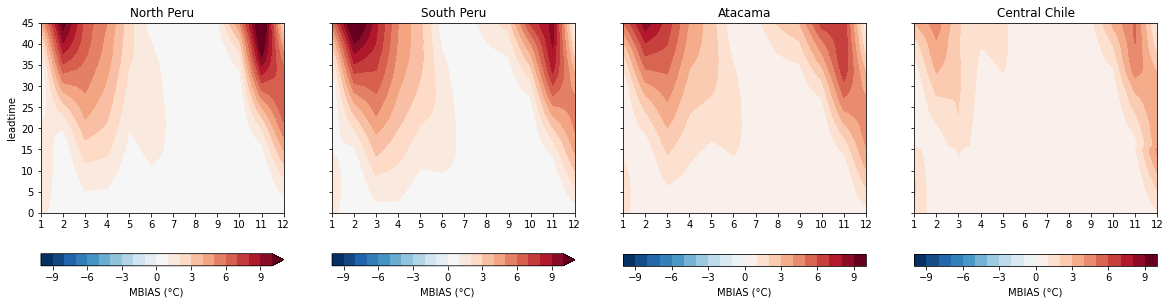

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [113]:
fig, ax  = plt.subplots(1,4, sharex=True, sharey=True, figsize=(20,5))

titles = ['North Peru', 'South Peru', 'Atacama', 'Central Chile']
for i,point in enumerate([nperu,speru, atacama, chilecentral]):
    variable       = 'sst_anomaly'
    reforecasts_df = reforecasts.sel(index=point['reforecasts']).mean('index')[variable].convert_calendar('noleap')
    glorys12_df    = glorys12.sel(index=point['glorys12']).mean('index')[variable].sel(time=slice("2000-01-06","2050")).dropna('time').convert_calendar('noleap')

    # CORR = [xr.corr(dict(reforecasts_df.groupby('time.month'))[d],dict(glorys12_df.groupby('time.month'))[d], 'time') for d in range(1,13)]
    CORR = [((dict(reforecasts_df.groupby('time.month'))[d]-dict(glorys12_df.groupby('time.month'))[d])).mean('time') for d in range(1,13)]
    CORR = xr.concat(CORR, 'month')**2
    CORR.coords['month'] = range(1,13)
    plt.figure(figsize=(10,8))
    CORR.plot.contourf(x='month', cmap='RdBu_r', levels=np.arange(-10,10+1,1), ax=ax[i], cbar_kwargs={'orientation':'horizontal','label':'MBIAS (°C)'})
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_xticks(np.arange(1,13))
    
ax[0].set_ylabel('leadtime')